# LAB 5-BIS: Graph Representation Learnin with Node2Vec for Recommender System - Movielens case study

Giorgio Lazzarinetti - My Contacts
For any questions or doubts you can find my contacts here:

giorgio.lazzarinetti@unimib.it g.lazzarinetti@campus.unimib.it


## Notebook Outline

- **Introduction to Movie Graph**
- **LAB CHALLENGE: Representation Learning for Movie on Graph**

In [2]:
# NECESSARY IMPIRT
import os
from collections import defaultdict
import math
import networkx as nx
import random
from tqdm import tqdm
from zipfile import ZipFile
from urllib.request import urlretrieve
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## MOVIES GRAPH

In the following er are going to see how we can model recommender system with graph. in particular we are going to build a network of movies, by considering movies connected if they have been liked by the same user.

Since we want to keep models simple and small we are going to use a smaller dataset with respect to the 100k dataset. The used dataset is the ml-latest-small. You can download it here: http://files.grouplens.org/datasets/movielens/ml-latest-small.zip. After that to use it, save it in your colab directory.

In [3]:
urlretrieve(
    "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip", "movielens.zip"
)
ZipFile("movielens.zip", "r").extractall()

### Movies and Ratings

let's read the movies.csv file and the ratings.csv file. In the following we are going to focus mainly on movies and not on users. We are not going to use direct movies features, the only fact we are going to rely on is the preferences expressed by users through ratings.

In [4]:
# Load movies to a DataFrame.
movies = pd.read_csv("ml-latest-small/movies.csv")
movies.head(5)
# Create a `movieId` string.
movies["movieId"] = movies["movieId"].apply(lambda x: f"movie_{x}")

# Load ratings to a DataFrame.
ratings = pd.read_csv("ml-latest-small/ratings.csv")
ratings.head(5)
# Convert the `ratings` to floating point
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))
# Create the `movie_id` string.
ratings["movieId"] = ratings["movieId"].apply(lambda x: f"movie_{x}")

print("Movies data shape:", movies.shape)
print("Ratings data shape:", ratings.shape)

Movies data shape: (9742, 3)
Ratings data shape: (100836, 4)


In [5]:
movies.head(5)

,movieId,title,genres
0,movie_1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,movie_2,Jumanji (1995),Adventure|Children|Fantasy
2,movie_3,Grumpier Old Men (1995),Comedy|Romance
3,movie_4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,movie_5,Father of the Bride Part II (1995),Comedy


In [6]:
ratings.head(5)

,userId,movieId,rating,timestamp
0,1,movie_1,4.0,964982703
1,1,movie_3,4.0,964981247
2,1,movie_6,4.0,964982224
3,1,movie_47,5.0,964983815
4,1,movie_50,5.0,964982931


In [7]:
# these function will be used to plot the movies and see the results
def get_movie_title_by_id(movieId):
    return list(movies[movies.movieId == movieId].title)[0]

def get_movie_id_by_title(title):
    return list(movies[movies.title == title].movieId)[0]

In [ ]:
def get_movie_id_by_title(title):
    title = title.strip().lower()
    result = movies[movies['title'].str.strip().str.lower() == title].movieId
    if not result.empty:
        return result.iloc[0]
    else:
        return None


### Construct the movies graph

We create an edge between two movie nodes in the graph if both movies are rated by the same user >= min_rating. The weight of the edge will be based on the pointwise mutual information between the two movies, which is computed as: $log(xy) - log(x) - log(y) + log(D)$, where:

- xy is how many users rated both movie x and movie y with >= min_rating.
- x is how many users rated movie x >= min_rating.
- y is how many users rated movie y >= min_rating.
- D total number of movie ratings >= min_rating.

In [9]:
min_rating = 5
#dictionary that counts how many times a pair of movies have been evaluated 5 by the same user
pair_frequency = defaultdict(int)
#dictionary that counts how many times each film received evaluation 5
item_frequency = defaultdict(int)

# Filter instances where rating is greater than or equal to min_rating.
rated_movies = ratings[ratings.rating >= min_rating]
# Group instances by user.
# this produces a list of tuples, where each tuple contains a userId and the subset of related_movies seen by that user and rated 5
movies_grouped_by_users = list(rated_movies.groupby("userId"))

for group in tqdm(
    movies_grouped_by_users,
    position=0,
    leave=True,
    desc="Compute movie rating frequencies",
):
    # Get a list of movies rated by the user.
    current_movies = list(group[1]["movieId"])

    #for each set of movies evaluated 5 seen by a user we build the item frequency dictionary
    #to count how many times that movie has been evaluated 5
    #then, given that the movies are ordered, for each movie in the list, we go trhough the movie in the following position
    # and we pair each of these, since they have been both evaluated 5 by the same user
    # these pairs are added to the pair frequency dictionary, counting how many times they have been rated 5 by the same user
    for i in range(len(current_movies)):
        item_frequency[current_movies[i]] += 1
        for j in range(i + 1, len(current_movies)):
            x = min(current_movies[i], current_movies[j])
            y = max(current_movies[i], current_movies[j])
            pair_frequency[(x, y)] += 1


Compute movie rating frequencies: 100%|██████████| 573/573 [00:00<00:00, 898.10it/s] 


In [10]:
min_weight = 10
D = math.log(sum(item_frequency.values()))

# Create the movies undirected graph.
movies_graph = nx.Graph()
# Add weighted edges between movies.
# This automatically adds the movie nodes to the graph.
for pair in tqdm(
    pair_frequency, position=0, leave=True, desc="Creating the movie graph"
):
    x, y = pair
    xy_frequency = pair_frequency[pair]
    x_frequency = item_frequency[x]
    y_frequency = item_frequency[y]
    pmi = math.log(xy_frequency) - math.log(x_frequency) - math.log(y_frequency) + D
    weight = pmi * xy_frequency
    # Only include edges with weight >= min_weight.
    if weight >= min_weight:
        movies_graph.add_edge(x, y, weight=weight)

Creating the movie graph: 100%|██████████| 298586/298586 [00:00<00:00, 403480.81it/s]


In [11]:
print("Total number of graph nodes:", movies_graph.number_of_nodes())
print("Total number of graph edges:", movies_graph.number_of_edges())

Total number of graph nodes: 1405
Total number of graph edges: 40043


In [12]:
vocabulary = ["NA"] + list(movies_graph.nodes)
vocabulary_lookup = {token: idx for idx, token in enumerate(vocabulary)}

## LAB CHALLENGE: Neural Matrix Factorization
By now we have built the movies graph. This have been done creating an edge between two movie nodes in the graph if both movies are rated by the same user >= min_rating. We also weighted the edges, based on the pointwise mutual information between the two movies, which is computed as: $log(xy) - log(x) - log(y) + log(D)$.

Let's now build a suitable representation for such movies and inspect the results:
- TASK1: Define the function random_walk and generate_examples to build the walks and the training pair for the Skip-Gram model. In doing this task, in the function random_walk, do not take the next step completely at random, but base the next step on the weight of the edge that link two nodes (the higher the weight the higher the probability to take that step). A draft of the solution is proposed.
- TASK 2: after building the walks generate some samples for target, context, labels and weights and put these samples in a DataLoader that can be used to train the Skip-Gram model.
- TASK 3: define and train the Word2Vec model
- TASK 4: given the list of movies provided, build the embedding using the trained model and visualize the results. In particular, for each movie get the 5 more similar movies according to a similarity function you want. Then reduce the dimension of the embeddings produced to visualize these movies in a graph.

## TASK 1
Fill in the function where TODO is present so that random_walk and generate_examples to build the walks and the training pair for the Skip-Gram model work. In doing this task, in the function random_walk, do not take the next step completely at random, but base the next step on the weight of the edge that link two nodes (the higher the weight the higher the probability to take that step).

In [13]:
def next_step(graph, previous, current, p, q):
    neighbors = list(graph.neighbors(current))

    weights = []
    # Adjust the weights of the edges to the neighbors with respect to p and q.
    for neighbor in neighbors:
        if neighbor == previous:
            # Control the probability to return to the previous node.
            weights.append(graph[current][neighbor]["weight"] / p)
        elif graph.has_edge(neighbor, previous):
            # The probability of visiting a local node.
            weights.append(graph[current][neighbor]["weight"])
        else:
            # Control the probability to move forward.
            weights.append(graph[current][neighbor]["weight"] / q)

    # Compute the probabilities of visiting each neighbor.
    weight_sum = sum(weights)
    probabilities = [weight / weight_sum for weight in weights]
    # Probabilistically select a neighbor to visit.
    next = np.random.choice(neighbors, size=1, p=probabilities)[0]
    return next


def random_walk(graph, num_walks, num_steps, p, q):
    walks = []
    nodes = list(graph.nodes())
    # Perform multiple iterations of the random walk.
    for walk_iteration in range(num_walks):
        random.shuffle(nodes)

        for node in tqdm(
            nodes,
            position=0,
            leave=True,
            desc=f"Random walks iteration {walk_iteration + 1} of {num_walks}",
        ):
            # Start the walk with a random node from the graph.
            walk = [node]
            # Randomly walk for num_steps.
            while len(walk) < num_steps:
                current = walk[-1]
                previous = walk[-2] if len(walk) > 1 else None
                # Compute the next node to visit.
                next = next_step(graph, previous, current, p, q)
                walk.append(next)
            # Replace node ids (movie ids) in the walk with token ids.
            walk = [vocabulary_lookup[token] for token in walk]
            # Add the walk to the generated sequence.
            walks.append(walk)

    return walks

In [14]:
# Random walk return parameter.
p = 1
# Random walk in-out parameter.
q = 1
# Number of iterations of random walks.
num_walks = 5
# Number of steps of each random walk.
num_steps = 10
walks = random_walk(movies_graph, num_walks, num_steps, p, q)

print("Number of walks generated:", len(walks))

Random walks iteration 5 of 5: 100%|██████████| 1405/1405 [00:06<00:00, 230.44it/s]

Number of walks generated: 7025


## TASK 2:
Fill in the function where TODO is present to generate some samples for target, context, labels and weights and put these samples in a DataLoader that can be used to train the Skip-Gram model

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import defaultdict
from tqdm import tqdm

import numpy as np

# Function to generate positive and negative examples
def generate_examples(sequences, window_size, num_negative_samples, vocabulary_size):
    example_weights = defaultdict(int)
    for sequence in tqdm(sequences, position=0, leave=True, desc="Generating positive and negative examples"):
        pairs, labels = [], []
        for i, target in enumerate(sequence):
            context_indices = list(range(max(0, i - window_size), min(len(sequence), i + window_size + 1)))
            context_indices.remove(i)
            for context_index in context_indices:
                pairs.append((target, sequence[context_index]))
                labels.append(1)
                for _ in range(num_negative_samples):
                    negative_sample = np.random.randint(0, vocabulary_size)
                    while negative_sample == target:
                        negative_sample = np.random.randint(0, vocabulary_size)
                    pairs.append((target, negative_sample))
                    labels.append(0)
        for idx in range(len(pairs)):
            pair = pairs[idx]
            label = labels[idx]
            target, context = min(pair[0], pair[1]), max(pair[0], pair[1])
            if target == context:
                continue
            entry = (target, context, label)
            example_weights[entry] += 1

    targets, contexts, labels, weights = [], [], [], []
    for entry in example_weights:
        weight = example_weights[entry]
        target, context, label = entry
        targets.append(target)
        contexts.append(context)
        labels.append(label)
        weights.append(weight)

    return np.array(targets), np.array(contexts), np.array(labels), np.array(weights)

# Generate examples
num_negative_samples = 4
targets, contexts, labels, weights = generate_examples(
    sequences=walks,
    window_size=num_steps,
    num_negative_samples=num_negative_samples,
    vocabulary_size=len(vocabulary),
)

Generating positive and negative examples: 100%|██████████| 7025/7025 [00:19<00:00, 362.31it/s]


In [21]:
print(f"Targets shape: {targets.shape}")
print(f"Contexts shape: {contexts.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Weights shape: {weights.shape}")

Targets shape: (881199,)
Contexts shape: (881199,)
Labels shape: (881199,)
Weights shape: (881199,)


In [22]:
# Convert the data into PyTorch Dataset and DataLoader objects
class SkipGramDataset(torch.utils.data.Dataset):
    def __init__(self, targets, contexts, labels, weights):
        self.targets = targets
        self.contexts = contexts
        self.labels = labels
        self.weights = weights

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return {
            'target': self.targets[idx],
            'context': self.contexts[idx],
            'label': self.labels[idx],
            'weight': self.weights[idx]
        }

batch_size = 1024
dataset = SkipGramDataset(targets, contexts, labels, weights)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

## TASK 3:
define and train the Word2Vec model. In this you are completely free, but you can take benefit from the functions seen during class.

**Of the following you can modify whatever you want to let it fit with the function you wrote.**

**this one of the methodes**

In [36]:
"""# Define the Word2Vec model
class Word2Vec(nn.Module):
    def __init__(self, voc_size, embedding_size):
        super(Word2Vec, self).__init__()

        self.voc_size = voc_size
        self.embedding_size = embedding_size

        # parameters between -1 and + 1
        self.W = nn.Parameter(-2 * torch.rand(voc_size, embedding_size) + 1) # voc_size > embedding_size Weight
        self.V = nn.Parameter(-2 * torch.rand(embedding_size, voc_size) + 1) # embedding_size > voc_size Weight

    def forward(self, X):
        # X : [batch_size, voc_size], self.W: [voc_size, embedding_size]
        hidden_layer = torch.matmul(X, self.W) # hidden_layer : [batch_size, embedding_size]
        # self.V: [voc_size, embedding_size]
        output_layer = torch.matmul(hidden_layer, self.V) # output_layer : [batch_size, voc_size]
        #return output_layer
        return nn.functional.softmax(output_layer)

# Training the model
voc_size = len(vocabulary)
embedding_size = 50
model = Word2Vec(voc_size, embedding_size)
model.train()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 1000
for epoch in range(num_epochs):
    total_loss = 0
    for batch in data_loader:
        input_batch = torch.zeros(len(batch['target']), voc_size)
        target_batch = torch.LongTensor(batch['label'])
        for i in range(len(batch['target'])):
            input_batch[i][batch['target'][i]] = 1

        optimizer.zero_grad()
        output = model(input_batch)
        loss = criterion(output, target_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(data_loader)}')
    
"""

"# Define the Word2Vec model\nclass Word2Vec(nn.Module):\n    def __init__(self, voc_size, embedding_size):\n        super(Word2Vec, self).__init__()\n\n        self.voc_size = voc_size\n        self.embedding_size = embedding_size\n\n        # parameters between -1 and + 1\n        self.W = nn.Parameter(-2 * torch.rand(voc_size, embedding_size) + 1) # voc_size > embedding_size Weight\n        self.V = nn.Parameter(-2 * torch.rand(embedding_size, voc_size) + 1) # embedding_size > voc_size Weight\n\n    def forward(self, X):\n        # X : [batch_size, voc_size], self.W: [voc_size, embedding_size]\n        hidden_layer = torch.matmul(X, self.W) # hidden_layer : [batch_size, embedding_size]\n        # self.V: [voc_size, embedding_size]\n        output_layer = torch.matmul(hidden_layer, self.V) # output_layer : [batch_size, voc_size]\n        #return output_layer\n        return nn.functional.softmax(output_layer)\n\n# Training the model\nvoc_size = len(vocabulary)\nembedding_size = 50\nm

**This another methode because the loss decrese slowly and the model nedd alot of epochs du the computational of softmax**

In [ ]:
"""import torch
import torch.nn as nn
import torch.optim as optim

class Word2Vec(nn.Module):
    def __init__(self, voc_size, embedding_size):
        super(Word2Vec, self).__init__()

        self.voc_size = voc_size
        self.embedding_size = embedding_size

        # Xavier initialization for weights
        self.W = nn.Parameter(torch.nn.init.xavier_uniform_(torch.empty(voc_size, embedding_size)))
        self.V = nn.Parameter(torch.nn.init.xavier_uniform_(torch.empty(embedding_size, voc_size)))

    def forward(self, X):
        hidden_layer = torch.matmul(X, self.W)  # hidden_layer : [batch_size, embedding_size]
        output_layer = torch.matmul(hidden_layer, self.V)  # output_layer : [batch_size, voc_size]
        return nn.functional.softmax(output_layer, dim=1)  # Apply softmax along the last dimension

# Assuming vocabulary and data_loader are defined

# Hyperparameters
voc_size = len(vocabulary)
embedding_size = 50
learning_rate = 0.001
num_epochs = 5

# Initialize model, criterion, and optimizer
model = Word2Vec(voc_size, embedding_size)
model.train()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)  # Decay LR by 0.9 every 10 epochs

# Training loop
for epoch in range(num_epochs):
    total_loss = 0
    for batch in data_loader:
        # Efficiently create input_batch
        input_batch = torch.zeros(len(batch['target']), voc_size)
        target_batch = torch.LongTensor(batch['label'])
        input_batch.scatter_(1, torch.LongTensor(batch['target']).unsqueeze(1), 1)

        optimizer.zero_grad()
        output = model(input_batch)
        loss = criterion(output, target_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    scheduler.step()  # Adjust the learning rate

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(data_loader)}')
"""

**This main model of this Assignment**

In [26]:
#Word2Vec model
class Word2Vec(nn.Module):
    def __init__(self, voc_size, embedding_size):
        super(Word2Vec, self).__init__()

        self.voc_size = voc_size
        self.embedding_size = embedding_size

        # parameters between -1 and + 1
        self.W = nn.Parameter(-2 * torch.rand(voc_size, embedding_size) + 1) # voc_size > embedding_size Weight
        self.V = nn.Parameter(-2 * torch.rand(embedding_size, voc_size) + 1) # embedding_size > voc_size Weight

    def forward(self, X):
        # X : [batch_size, voc_size], self.W: [voc_size, embedding_size]
        hidden_layer = torch.matmul(X, self.W) # hidden_layer : [batch_size, embedding_size]
        # self.V: [voc_size, embedding_size]
        output_layer = torch.matmul(hidden_layer, self.V) # output_layer : [batch_size, voc_size]
        return output_layer
        #return nn.functional.softmax(output_layer,dim=1)

# Training the model
voc_size = len(vocabulary)
embedding_size = 50
model = Word2Vec(voc_size, embedding_size)
model.train()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20
for epoch in range(num_epochs):
    total_loss = 0
    for batch in data_loader:
        input_batch = torch.zeros(len(batch['target']), voc_size)
        target_batch = torch.LongTensor(batch['label'])
        for i in range(len(batch['target'])):
            input_batch[i][batch['target'][i]] = 1

        optimizer.zero_grad()
        output = model(input_batch)
        loss = criterion(output, target_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(data_loader)}')


Epoch 1/20, Loss: 2.5611134925024297
Epoch 2/20, Loss: 0.43141328672360324
Epoch 3/20, Loss: 0.41709388590025154
Epoch 4/20, Loss: 0.41494178235461626
Epoch 5/20, Loss: 0.4143268728020853
Epoch 6/20, Loss: 0.4140592248597627
Epoch 7/20, Loss: 0.4138813927752354
Epoch 8/20, Loss: 0.4137041060282101
Epoch 9/20, Loss: 0.4136071850336941
Epoch 10/20, Loss: 0.41343607124412796
Epoch 11/20, Loss: 0.4133420914030795
Epoch 12/20, Loss: 0.4133117872178901
Epoch 13/20, Loss: 0.41316783442037586
Epoch 14/20, Loss: 0.41311576235585096
Epoch 15/20, Loss: 0.4130822272320104
Epoch 16/20, Loss: 0.4130451120565993
Epoch 17/20, Loss: 0.41303179924496375
Epoch 18/20, Loss: 0.41296496703511193
Epoch 19/20, Loss: 0.4129318188568718
Epoch 20/20, Loss: 0.4128499721954647


## TASK 4
given the list of movies provided, build the embedding using the trained model and visualize the results. In particular, for each movie get the 5 more similar movies according to a similarity function you want. Then reduce the dimension of the embeddings produced to visualize these movies in a graph.

In [29]:
query_movies = [
    "Matrix, The (1999)",
    "Star Wars: Episode IV - A New Hope (1977)",
    "Lion King, The (1994)",
    "Terminator 2: Judgment Day (1991)",
    "Godfather, The (1972)",
]

In [38]:
movie_embeddings = model.W.detach().numpy()

#movie_embeddings = model.W.data.numpy()
print("Embeddings shape:", movie_embeddings.shape)
query_embeddings = []
for movie_title in query_movies:
    movieId = get_movie_id_by_title(movie_title)
    token_id = vocabulary_lookup[movieId]
    movie_embedding = movie_embeddings[token_id]
    query_embeddings.append(movie_embedding)

query_embeddings = np.array(query_embeddings)

similarities = np.dot(query_embeddings, movie_embeddings.T)
norms = np.linalg.norm(query_embeddings, axis=1)

# Normalize similarities
similarities = similarities / norms[:, np.newaxis]

# Find top-k similar movies for each query movie
top_k = 5
for idx, title in enumerate(query_movies):
    print(title)
    print("".rjust(len(title), "-"))
    similar_indices = np.argsort(similarities[idx])[::-1][:top_k]
    for sim_idx in similar_indices:
        similar_movieId = vocabulary[sim_idx]
        similar_title = get_movie_title_by_id(similar_movieId)
        print(f"- {similar_title}")
    print()

Embeddings shape: (1406, 50)
Matrix, The (1999)
------------------
- Matrix, The (1999)
- Chitty Chitty Bang Bang (1968)
- Go (1999)
- Gravity (2013)
- Little Women (1994)

Star Wars: Episode IV - A New Hope (1977)
-----------------------------------------
- Star Wars: Episode IV - A New Hope (1977)
- Alien (1979)
- X-Men: First Class (2011)
- Toy Story (1995)
- Almost Famous (2000)

Lion King, The (1994)
---------------------
- Lion King, The (1994)
- Avengers: Infinity War - Part I (2018)
- Predator (1987)
- Along Came Polly (2004)
- My Life as a Dog (Mitt liv som hund) (1985)

Terminator 2: Judgment Day (1991)
---------------------------------
- Terminator 2: Judgment Day (1991)
- Wrestler, The (2008)
- Cyrano de Bergerac (1990)
- L.A. Confidential (1997)
- Matrix Reloaded, The (2003)

Godfather, The (1972)
---------------------
- Godfather, The (1972)
- Blade Runner (1982)
- To Wong Foo, Thanks for Everything! Julie Newmar (1995)
- Robin Hood: Men in Tights (1993)
- 20,000 Leagues 

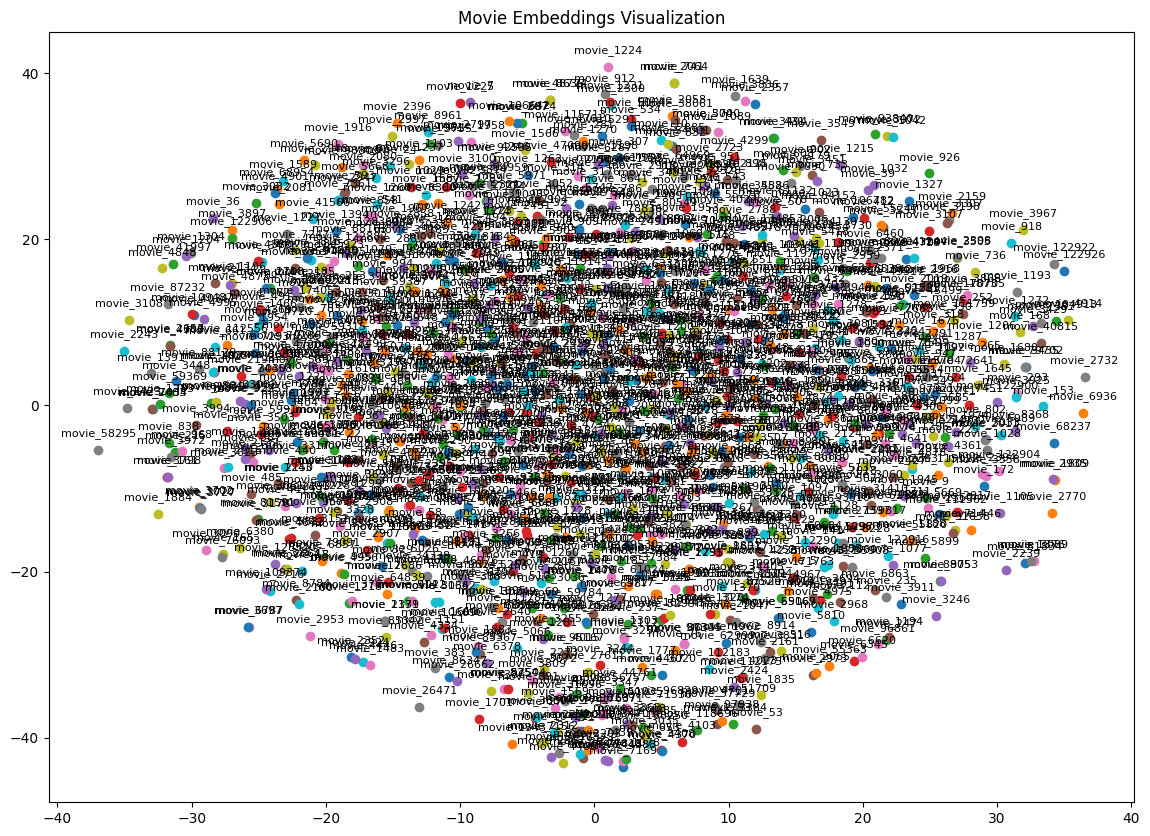

In [33]:
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity# Reduce dimensions and visualize
# Reduce dimensions and visualize
all_movies = vocabulary
movie_to_index = {movieId: idx for movieId, idx in vocabulary_lookup.items()}

all_embeddings = np.array([movie_embeddings[movie_to_index[movie]] for movie in all_movies])
# Create a mapping from movieId to index using vocabulary_lookup
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(all_embeddings)

plt.figure(figsize=(14, 10))
for i, movie in enumerate(all_movies):
    plt.scatter(reduced_embeddings[i, 0], reduced_embeddings[i, 1])
    if movie in query_movies:
        plt.annotate(movie, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=9, fontweight='bold')
    else:
        plt.annotate(movie, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=8)

plt.title("Movie Embeddings Visualization")
plt.show()

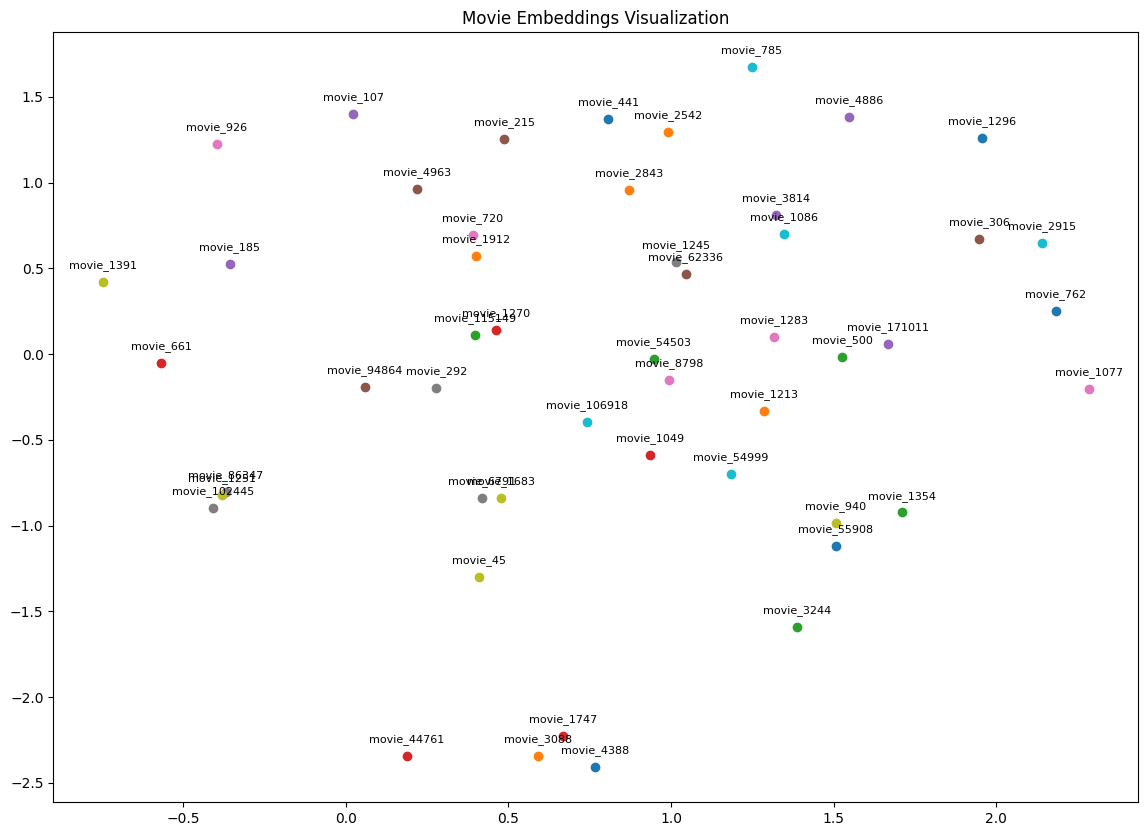

In [34]:
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# Sample 50 movies
sample_size = 50
sample_indices = np.random.choice(len(all_movies), sample_size, replace=False)
sample_movies = [all_movies[i] for i in sample_indices]
sample_embeddings = np.array([movie_embeddings[movie_to_index[movie]] for movie in sample_movies])

# Reduce dimensions using t-SNE
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(sample_embeddings)

# Plot the reduced embeddings
plt.figure(figsize=(14, 10))
for i, movie in enumerate(sample_movies):
    plt.scatter(reduced_embeddings[i, 0], reduced_embeddings[i, 1])
    if movie in query_movies:
        plt.annotate(movie, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=9, fontweight='bold')
    else:
        plt.annotate(movie, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=8)

plt.title("Movie Embeddings Visualization")
plt.show()


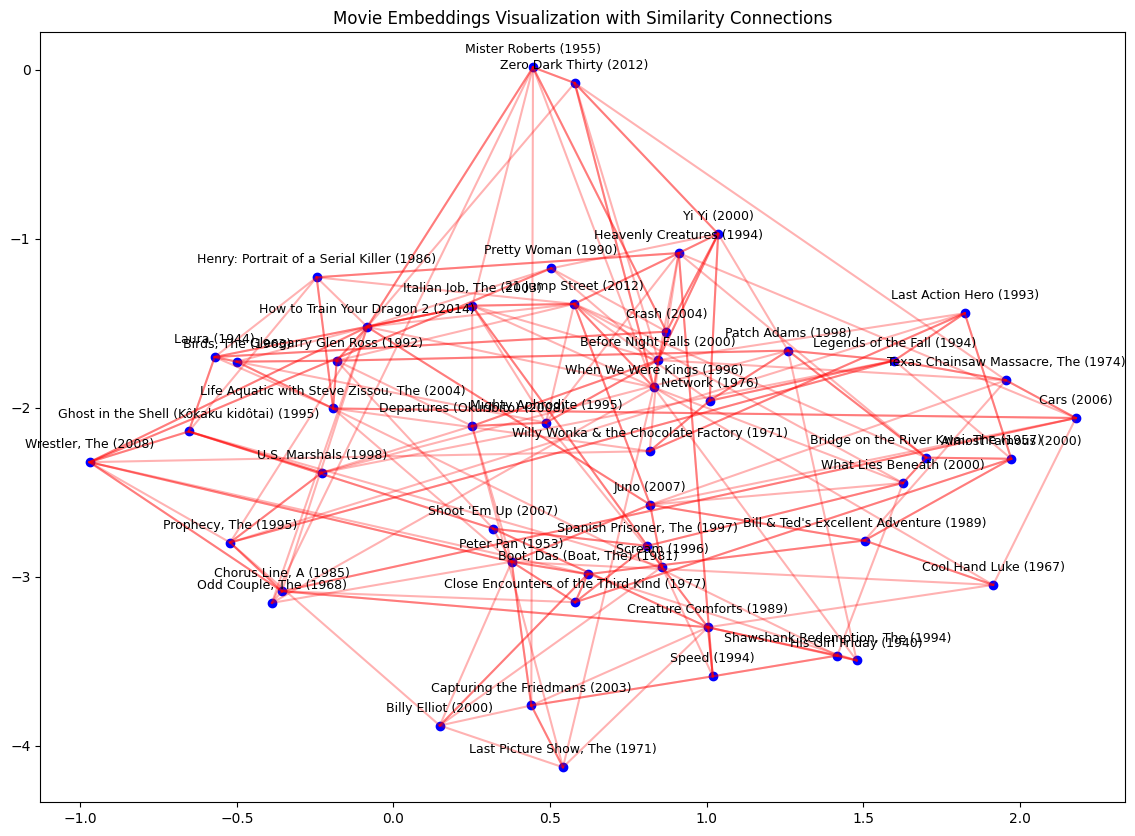

In [37]:
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity



# Sample 50 movies
sample_size = 50
sample_indices = np.random.choice(len(all_movies), sample_size, replace=False)
sample_movies = [all_movies[i] for i in sample_indices]
sample_embeddings = np.array([movie_embeddings[movie_to_index[movie]] for movie in sample_movies])

# Calculate similarity matrix for the sample
similarity_matrix = cosine_similarity(sample_embeddings)

# Reduce dimensions using t-SNE
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(sample_embeddings)

# Plot the reduced embeddings
plt.figure(figsize=(14, 10))
for i, movie in enumerate(sample_movies):
    plt.scatter(reduced_embeddings[i, 0], reduced_embeddings[i, 1], color='blue')
    plt.annotate(get_movie_title_by_id(movie), (reduced_embeddings[i, 0], reduced_embeddings[i, 1]),
                 textcoords="offset points", xytext=(0, 10), ha='center', fontsize=9)

# Draw lines to top 5 similar movies
top_k = 5
for i in range(sample_size):
    similar_indices = np.argsort(similarity_matrix[i])[::-1][1:top_k+1]  # Skip the first one (itself)
    for sim_idx in similar_indices:
        plt.plot([reduced_embeddings[i, 0], reduced_embeddings[sim_idx, 0]], 
                 [reduced_embeddings[i, 1], reduced_embeddings[sim_idx, 1]], 'r-', alpha=0.3)

plt.title("Movie Embeddings Visualization with Similarity Connections")
plt.show()
